# Scanpy: Data integration

In this tutorial we will look at different ways of integrating multiple single cell RNA-seq datasets. We will explore two different methods to correct for batch effects across datasets. We will also look at a quantitative measure to assess the quality of the integrated data. Seurat uses the data integration method presented in Comprehensive Integration of Single Cell Data, while Scran and Scanpy use a mutual Nearest neighbour method (MNN). Below you can find a list of the most recent methods for single data integration:

Markdown | Language | Library | Ref
--- | --- | --- | ---
CCA | R | Seurat | [Cell](https://www.sciencedirect.com/science/article/pii/S0092867419305598?via%3Dihub)
MNN | R/Python | Scater/Scanpy | [Nat. Biotech.](https://www.nature.com/articles/nbt.4091)
Conos | R | conos | [Nat. Methods](https://www.nature.com/articles/s41592-019-0466-z?error=cookies_not_supported&code=5680289b-6edb-40ad-9934-415dac4fdb2f)
Scanorama | Python | scanorama | [Nat. Biotech.](https://www.nature.com/articles/s41587-019-0113-3)


In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

sc.settings.set_figure_params(dpi=80)

/Users/asbj/miniconda3/envs/sc_course/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.7 numpy==1.17.3 scipy==1.3.1 pandas==0.25.3 scikit-learn==0.21.3 statsmodels==0.10.2 python-igraph==0.7.1 louvain==0.6.1


First need to load the QC filtered dataset and create individual adata objects per batch.

In [2]:
# Load the stored data object
save_file = './data/scanpy_dr_3pbmc.h5ad'
adata = sc.read_h5ad(save_file)


In [3]:
print(adata.X.shape)

(2527, 2472)


As the stored AnnData object contains scaled data based on variable genes, we need to make a new object with the raw counts and normalized it again. Variable gene selection should not be performed on the scaled data object, only do normalization and log transformation before variable genes selection. 


In [4]:
adata2 = sc.AnnData(X=adata.raw.X, var=adata.raw.var, obs = adata.obs)

sc.pp.normalize_per_cell(adata2, counts_per_cell_after=1e4)
sc.pp.log1p(adata2)



normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


### Detect variable genes

Variable genes can be detected across the full dataset, but then we run the risk of getting many batch-specific genes that will drive a lot of the variation. Or we can select variable genes from each batch separately to get only celltype variation. Here, we will do both as an example of how it can be done. 

First we will select genes based on the full dataset.



extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


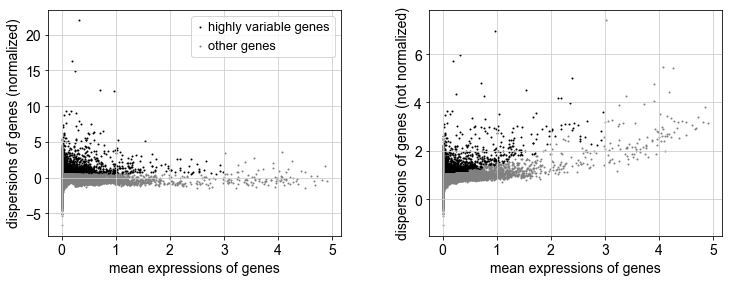

Highly variable genes: 2472


In [5]:
#variable genes for the full dataset
sc.pp.highly_variable_genes(adata2, min_mean=0.0125, max_mean=3, min_disp=0.5)

sc.pl.highly_variable_genes(adata2)

print("Highly variable genes: %d"%sum(adata2.var.highly_variable))

var_genes_all = adata2.var.highly_variable

Detect variable genes in each dataset separately using the `batch_key` parameter.


In [6]:
sc.pp.highly_variable_genes(adata2, min_mean=0.0125, max_mean=3, min_disp=0.5, batch_key = 'lib_prep')

print("Highly variable genes intersection: %d"%sum(adata2.var.highly_variable_intersection))

print("Number of batches where gene is variable:")
print(adata2.var.highly_variable_nbatches.value_counts())

var_genes_batch = adata2.var.highly_variable_nbatches > 0

extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Highly variable genes intersection: 748
Number of batches where gene is variable:
0    10788
1     3923
2     1307
3      748
Name: highly_variable_nbatches, dtype: int64


Compare overlap of the variable genes.

In [7]:
print("Any batch var genes: %d"%sum(var_genes_batch))
print("All data var genes: %d"%sum(var_genes_all))
print("Overlap: %d"%sum(var_genes_batch & var_genes_all))
print("Variable genes in all batches: %d"%sum(adata2.var.highly_variable_nbatches ==3))
print("Overlap batch instersection and all: %d"%sum(var_genes_all & adata2.var.highly_variable_intersection))


Any batch var genes: 5978
All data var genes: 0
Overlap: 0
Variable genes in all batches: 748
Overlap batch instersection and all: 0


Select all genes that are variable in at least 2 datasets and use for remaining analysis. 

In [8]:
var_select = adata2.var.highly_variable_nbatches > 1
var_genes = var_select.index[var_select]
len(var_genes)



2055

### Data integration

First we need to create individual AnnData objects from each of the datasets.

In [9]:
# split per batch into new objects.
batches = ['v2','v3','p3']
alldata = {}
for batch in batches:
    alldata[batch] = adata2[adata2.obs['lib_prep'] == batch,]

alldata    

{'v2': View of AnnData object with n_obs × n_vars = 932 × 16766 
     obs: 'batch', 'lib_prep', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'percent_mito', 'n_counts', 'percent_ribo', 'n_genes'
     var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection',
 'v3': View of AnnData object with n_obs × n_vars = 1069 × 16766 
     obs: 'batch', 'lib_prep', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'percent_mito', 'n_counts', 'per

Then perform batch correction with MNN. 

The function mnn_correct has the following input options:

```    
scanpy.api.pp.mnn_correct(*datas, var_index=None, var_subset=None, 
 batch_key='batch', index_unique='-', batch_categories=None, k=20, 
 sigma=1.0, cos_norm_in=True, cos_norm_out=True, svd_dim=None, 
 var_adj=True, compute_angle=False, mnn_order=None, svd_mode='rsvd', 
 do_concatenate=True, save_raw=False, n_jobs=None, **kwargs)
```

We run it with the option `save_raw=True` so that the uncorrected matrix will be stored in the slot `raw`.

In [10]:
cdata = sc.external.pp.mnn_correct(alldata['v2'],alldata['v3'],alldata['p3'], svd_dim = 50, batch_key = 'lib_prep', batch_categories = ['v2','v3','p3'],save_raw = True, var_subset = var_genes)



Performing cosine normalization...
Starting MNN correct iteration. Reference batch: 0
Step 1 of 2: processing batch 1
  Looking for MNNs...
  Computing correction vectors...
  Removing components...
  Adjusting variance...
  Applying correction...
Step 2 of 2: processing batch 2
  Looking for MNNs...
  Computing correction vectors...
  Removing components...
  Adjusting variance...
  Applying correction...
MNN correction complete. Gathering output...
Packing AnnData object...
Done.


The mnn_correct function returns a tuple with the AnnData object, list of cell pairs and of angles.Hence, cdata[0] is the new AnnData object. <br> We get corrected expression values for all genes even though only the selected genes were used for finding neighbor cells. For later analysis we want to do dimensionality reduction etc. on the variable genes only, so we will subset the data to only include the variable genes.


In [11]:
corr_data = cdata[0][:,var_genes]
corr_data.X.shape

(2527, 2055)

computing PCA with n_comps = 50
    finished (0:00:00)


... storing 'batch' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


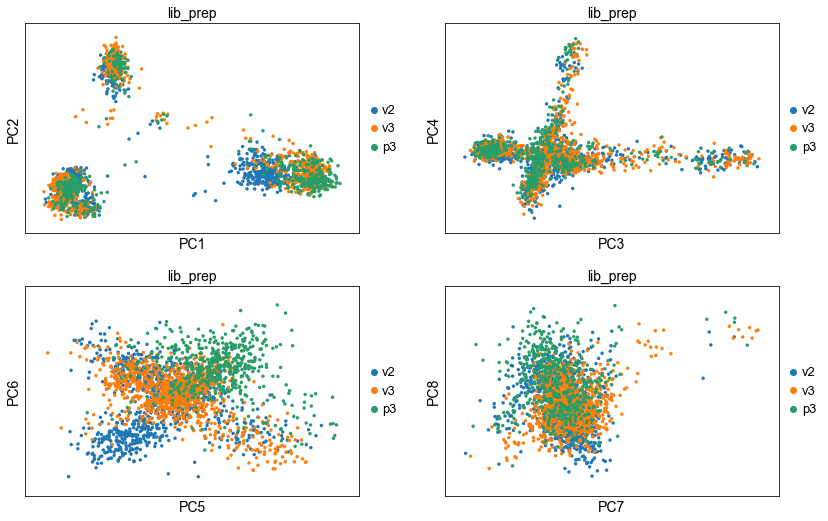

computing tSNE
    using 'X_pca' with n_pcs = 50
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:14)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:03)
computing UMAP


/Users/asbj/miniconda3/envs/sc_course/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 4 separate connected components using meta-embedding (experimental)
  n_components


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


In [12]:
# the variable genes defined are used by default by the pca function, 
# now we want to run on all the genes in the dataset
sc.tl.pca(corr_data, svd_solver = 'arpack', use_highly_variable = False)
sc.pl.pca(corr_data, components = ['1,2','3,4','5,6','7,8'], ncols=2, color='lib_prep')


# tSNE
sc.tl.tsne(corr_data, n_pcs = 50)
# UMAP, first with neighbor calculation 
sc.pp.neighbors(corr_data, n_pcs = 50, n_neighbors = 20)
sc.tl.umap(corr_data)



We can now plot the un-integrated and the integrated space reduced dimensions.


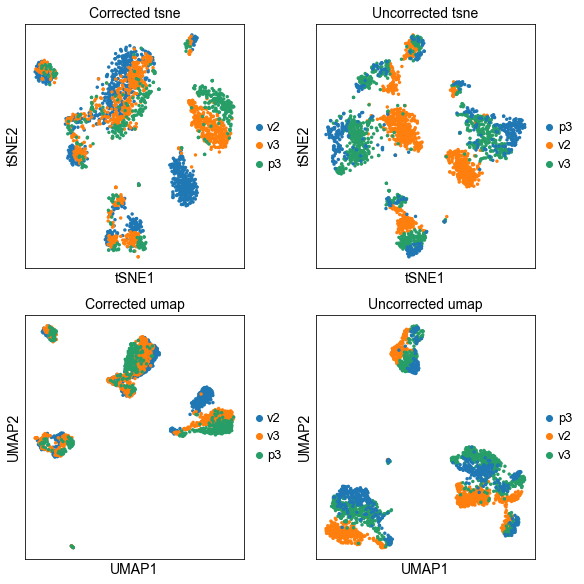

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(8,8),constrained_layout=True)
sc.pl.tsne(corr_data, color="lib_prep", title="Corrected tsne", ax=axs[0,0], show=False)
sc.pl.tsne(adata, color="lib_prep", title="Uncorrected tsne", ax=axs[0,1], show=False)
sc.pl.umap(corr_data, color="lib_prep", title="Corrected umap", ax=axs[1,0], show=False)
sc.pl.umap(adata, color="lib_prep", title="Uncorrected umap", ax=axs[1,1], show=False)


Finally, lets save the integrated data for further analysis.


In [14]:
save_file = './data/scanpy_mnn_corrected_3pbmc.h5ad'
corr_data.write_h5ad(save_file)

... storing 'feature_types' as categorical
... storing 'genome' as categorical


##Combat

Batch correction can also be performed with combat.<br>Note that ComBat batch correction requires a dense matrix format as input (which is already the case in this example).


In [15]:
# create a new object with raw counts
adata_combat = sc.AnnData(X=adata.raw.X, var=adata.raw.var, obs = adata.obs)

#normalize and log-transform
sc.pp.normalize_per_cell(adata_combat, counts_per_cell_after=1e4)
sc.pp.log1p(adata_combat)

# first store the raw data 
adata_combat.raw = adata_combat

# run combat
sc.pp.combat(adata_combat, key='lib_prep')

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
Standardizing Data across genes.

Found 3 batches

Found 0 numerical variables:
	

Found 21 genes with zero variance.
Fitting L/S model and finding priors

Finding parametric adjustments



/Users/asbj/miniconda3/envs/sc_course/lib/python3.6/site-packages/scanpy/preprocessing/_combat.py:235: RuntimeWarning: invalid value encountered in true_divide
  b_prior[i],
/Users/asbj/miniconda3/envs/sc_course/lib/python3.6/site-packages/scanpy/preprocessing/_combat.py:235: RuntimeWarning: divide by zero encountered in true_divide
  b_prior[i],


Adjusting data



extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Highly variable genes: 2975


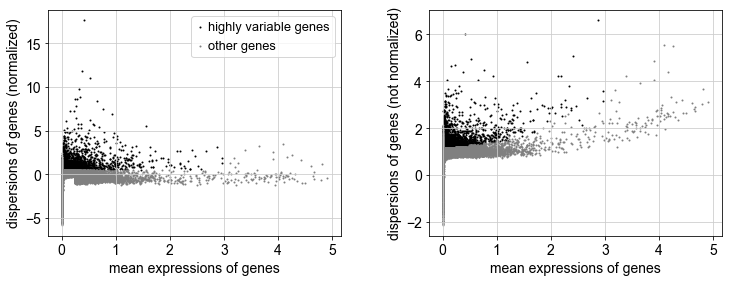

computing PCA with n_comps = 30
computing PCA on highly variable genes
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)
computing UMAP


/Users/asbj/miniconda3/envs/sc_course/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 3 separate connected components using meta-embedding (experimental)
  n_components


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)
computing tSNE
    using 'X_pca' with n_pcs = 30
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:15)


In [16]:
sc.pp.highly_variable_genes(adata_combat)
print("Highly variable genes: %d"%sum(adata_combat.var.highly_variable))
sc.pl.highly_variable_genes(adata_combat)


sc.pp.pca(adata_combat, n_comps=30, use_highly_variable=True, svd_solver='arpack')

sc.pp.neighbors(adata_combat, n_pcs =30)

sc.tl.umap(adata_combat)
sc.tl.tsne(adata_combat, n_pcs = 30)


In [17]:
# compare var_genes
var_genes_combat = adata_combat.var.highly_variable
print("With all data %d"%sum(var_genes_all))
print("With combat %d"%sum(var_genes_combat))
print("Overlap %d"%sum(var_genes_all & var_genes_combat))

print("With 2 batches %d"%sum(var_select))
print("Overlap %d"%sum(var_genes_combat & var_select))

With all data 0
With combat 2975
Overlap 0
With 2 batches 2055
Overlap 1481


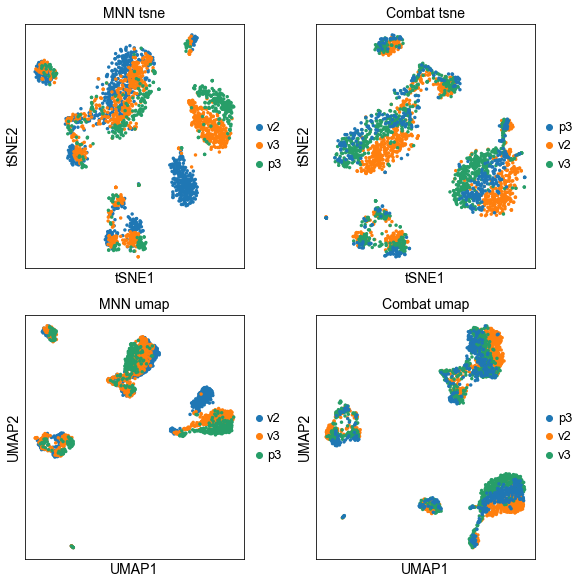

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(8,8),constrained_layout=True)
sc.pl.tsne(corr_data, color="lib_prep", title="MNN tsne", ax=axs[0,0], show=False)
sc.pl.tsne(adata_combat, color="lib_prep", title="Combat tsne", ax=axs[0,1], show=False)
sc.pl.umap(corr_data, color="lib_prep", title="MNN umap", ax=axs[1,0], show=False)
sc.pl.umap(adata_combat, color="lib_prep", title="Combat umap", ax=axs[1,1], show=False)


In [19]:
save_file = './data/scanpy_mnn_corrected_3pbmc.h5ad'
corr_data.write_h5ad(save_file)